In [21]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from tqdm.autonotebook import tqdm, trange
import time

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
# открываем доступ к Goggle.disk чтобы читать

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
# использование Cuda (GPU), если доступно

import torch
import numpy as np

gpu = torch.cuda.is_available()

if not gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# unzip and load data from google drive

# !ls /content/gdrive/     # название корневой директории

!unzip -q /content/gdrive/MyDrive/journey-springfield.zip
# !ls     # посмотреть что получилось после распаковки

# !ls train     # посмотреть что в папке 'train'
# !ls testset

from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

print(TRAIN_DIR, TEST_DIR)

train/simpsons_dataset testset/testset


In [ ]:
# Проверка, что данные загрузились из файлов в переменные

# train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
# test_files = list(TEST_DIR.rglob('*.jpg'))
# print(len(train_val_files)) #=> 20933
# print(len(test_files)) #=> 991

20933
991


In [5]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [6]:
# режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# масштабирование к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        else:
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.RandomHorizontalFlip(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])    
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
class SimpsonsDataset_augmentations(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        else:
          transform = transforms.Compose([
              transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),    # авто-аугментация из набора AutoAugmentPolicy.SVHN
              transforms.ToTensor(),              
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])    
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
        # return np.array(image)

In [8]:
# функция для отрисовки

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Создаем train, val датасэты

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
val_dataset = SimpsonsDataset_augmentations(val_files, mode='val')
train_dataset = SimpsonsDataset_augmentations(train_files, mode='train')

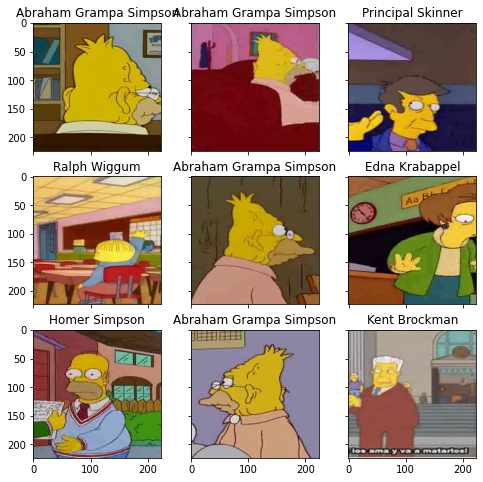

In [11]:
# Посмотрим на несколько сэмплов из датасета

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,15000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [12]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader, desc="Training_batches"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [13]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader, desc="Validation_batches"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc.cpu().numpy().item()

In [14]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    best_acc = 0.0
    best_model_wts = model.state_dict()
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            # print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    model.load_state_dict(best_model_wts)        
    return model, history

In [15]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [16]:
n_classes = len(np.unique(train_val_labels))

**Загружаем модели для обучения**

In [ ]:
# Начнем с AlexNet. Загрузим ее вместе с весами

model_Alex = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# Посмотрим на архитектуру AlexNet

model_Alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# не будем трогать feature extractor ((features): Sequential), заменим только 'classifier'
# на вход перовому полносвязному слою поступает вектор из 9216 фич. Будем использовать только его, остальные слои удалим.
# поменяем только классификатор в соответствии с количеством наших классов (42)

fc_num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_Alex.classifier = nn.Linear(fc_num_features, n_classes)
model_Alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [ ]:
model_Alex.to(DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [ ]:
model_Alex, history = train(train_dataset, val_dataset, model=model_Alex, epochs=4, batch_size=64)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.9604     val_loss 0.9487 train_acc 0.7499 val_acc 0.7713


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.6707     val_loss 0.8620 train_acc 0.8231 val_acc 0.7933


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.5509     val_loss 0.7303 train_acc 0.8527 val_acc 0.8145


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.5379     val_loss 0.6461 train_acc 0.8553 val_acc 0.8416


**ALexNet feature extractor**

In [ ]:
model_Alex_FE = models.alexnet(pretrained=True)

In [ ]:
# веса feature extractor оставим из предобученной модели, будем обучать только классификатор. Для этого уберем расчет градиентов для Feature extractor

for param in model_Alex_FE.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
# замораживаем параметры (веса)
for param in model_Alex_FE.parameters():
    param.requires_grad = False

# Заменяем Fully-Connected слой на наш линейный классификатор
model_Alex_FE.classifier = nn.Linear(fc_num_features, n_classes)

# Использовать ли GPU
if gpu:
    model_Alex_FE = model_Alex_FE.cuda()

In [ ]:
# проверяем

for param in model_Alex_FE.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
# Обучаем

# history_feature_extractor = train(train_dataset, val_dataset, model=model_Alex_extractor, epochs=2, batch_size=64)

**Обучим несколько последних слоев Feature Extractor и выходной слой**

In [ ]:
model_Alex_mixed = models.alexnet(pretrained=True)

# будем дообучать последнии 5 слоев
layers_to_unfreeze = 5 
fc_num_features = 9216

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_Alex_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# Заменяем Fully-Connected слой на наш линейный классификатор
model_Alex_mixed.classifier = nn.Linear(fc_num_features, n_classes)

# Использовать ли GPU
if gpu:
    model_Alex_mixed = model_Alex_mixed.cuda()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = torch.optim.Adam(list(model_Alex_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_Alex_mixed.classifier.parameters()), lr=1e-3)

In [ ]:
for param in model_Alex_mixed.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
True
True
True
True
True
True


In [ ]:
from torchsummary import summary

summary(model_Alex_mixed, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def train_for_freezing_layers(train_files, val_files, model, epochs, batch_size, opt):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    pbar = trange(epochs, desc="Epoch:")

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in pbar:
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            # print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
history_freezing_layers = train_for_freezing_layers(train_dataset, val_dataset, model=model_Alex_mixed, epochs=7, batch_size=64, opt=optimizer)

Epoch::   0%|          | 0/7 [00:00<?, ?it/s]

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.8452     val_loss 1.8299 train_acc 0.5103 val_acc 0.6548


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.9830     val_loss 1.4664 train_acc 0.7383 val_acc 0.7488


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.7508     val_loss 1.7944 train_acc 0.7996 val_acc 0.7207


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.6145     val_loss 1.7938 train_acc 0.8329 val_acc 0.7298


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.5291     val_loss 1.3635 train_acc 0.8550 val_acc 0.7788


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.4656     val_loss 1.6781 train_acc 0.8729 val_acc 0.7826


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.4584     val_loss 1.5968 train_acc 0.8744 val_acc 0.7669


**VGG-16**
Проделаем те же операции для архитектуры VGG. Возмем ее 16-слойную версию

In [ ]:
# model_vgg = models.vgg16(pretrained=True)
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# на вход классифкатора потупает 25088 фичей
fc_num_features = 25088

for par in model_vgg.parameters():
    par.requires_grad = False

model_vgg.classifier = nn.Linear(fc_num_features, n_classes)

if gpu:
    model_vgg.cuda()

In [ ]:
# обучение

# history_vgg = train(train_dataset, val_dataset, model=model_vgg, epochs=6, batch_size=64)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_vgg_mixed = models.vgg16(pretrained=True)

# будем дообучать последнии 5 слоев
layers_to_unfreeze = 5 
fc_num_features = 25088
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_vgg_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# Заменяем Fully-Connected слой на наш линейный классификатор
model_vgg_mixed.classifier = nn.Linear(fc_num_features, n_classes)

# Использовать ли GPU
if gpu:
    model_vgg_mixed = model_vgg_mixed.cuda()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = torch.optim.Adam(list(model_vgg_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_vgg_mixed.classifier.parameters()), lr=1e-3)

for param in model_vgg_mixed.parameters():
    print(param.requires_grad)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [ ]:
summary(model_vgg_mixed, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
history_vgg_freezing_layers = train_for_freezing_layers(train_dataset, val_dataset, model=model_vgg_mixed, epochs=7, batch_size=64, opt=optimizer)

Epoch::   0%|          | 0/7 [00:00<?, ?it/s]

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.7354     val_loss 1.2419 train_acc 0.5433 val_acc 0.6993


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.9565     val_loss 0.9526 train_acc 0.7504 val_acc 0.7778


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.7283     val_loss 1.0193 train_acc 0.8041 val_acc 0.7831


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.6011     val_loss 1.2651 train_acc 0.8395 val_acc 0.7459


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.5356     val_loss 1.0563 train_acc 0.8550 val_acc 0.8082


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.4857     val_loss 0.9302 train_acc 0.8682 val_acc 0.8219


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.4259     val_loss 1.2172 train_acc 0.8832 val_acc 0.7925


In [ ]:
import pandas as pd
metrics_df = pd.DataFrame(columns=['Name', 'Epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

epoch = 0
for tr_loss, tr_acc, val_loss, val_acc in history_freezing_layers:
    epoch += 1
    temp_frame = pd.Series(['AlexNet_5_unfreezing_layers', epoch, tr_loss, val_loss, tr_acc, val_acc], index=metrics_df.columns )
    metrics_df = metrics_df.append(temp_frame, ignore_index=True)

epoch = 0
for tr_loss, tr_acc, val_loss, val_acc in history_vgg_freezing_layers:
    epoch += 1
    temp_frame = pd.Series(['VGG-16_5_unfreezing_layers', epoch, tr_loss, val_loss, tr_acc, val_acc], index=metrics_df.columns )
    metrics_df = metrics_df.append(temp_frame, ignore_index=True)

metrics_df

,Name,Epoch,train_loss,val_loss,train_acc,val_acc
0,AlexNet_5_unfreezing_layers,1,1.845241,1.829929,0.510287,0.654757
1,AlexNet_5_unfreezing_layers,2,0.982959,1.466420,0.738327,0.748758
2,AlexNet_5_unfreezing_layers,3,0.750797,1.794429,0.799605,0.720673
3,AlexNet_5_unfreezing_layers,4,0.614457,1.793810,0.832856,0.729843
4,AlexNet_5_unfreezing_layers,5,0.529069,1.363469,0.855023,0.778754
5,AlexNet_5_unfreezing_layers,6,0.465582,1.678071,0.872922,0.782575
6,AlexNet_5_unfreezing_layers,7,0.458400,1.596819,0.874387,0.766909
7,VGG-16_5_unfreezing_layers,1,1.735433,1.241949,0.543347,0.699274
8,VGG-16_5_unfreezing_layers,2,0.956511,0.952644,0.750430,0.777799
9,VGG-16_5_unfreezing_layers,3,0.728348,1.019264,0.804064,0.783149


**EfficientNet**

In [17]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=550f5655db211bfaffb8db431cc5725ffd43f8febd6f8a8ba0f6a735eaf3ddcb
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [18]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


In [ ]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [19]:
for param in model.parameters():
    param.requires_grad = False
model._fc = nn.Linear(in_features=1792, out_features=n_classes, bias=True)

In [22]:
if gpu:
    model = model.cuda()
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 48, 1, 1]             624
         I

In [23]:
# обучение

history_Ef_net = train(train_dataset, val_dataset, model=model, epochs=7, batch_size=64)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 2.3452     val_loss 1.7304 train_acc 0.4839 val_acc 0.6586


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 1.3973     val_loss 1.2851 train_acc 0.6942 val_acc 0.6995


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 1.0660     val_loss 1.1314 train_acc 0.7467 val_acc 0.7186


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.8963     val_loss 1.0518 train_acc 0.7839 val_acc 0.7291


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.7911     val_loss 1.0028 train_acc 0.8066 val_acc 0.7396


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.7084     val_loss 0.9705 train_acc 0.8240 val_acc 0.7459


Training_batches:   0%|          | 0/246 [00:00<?, ?it/s]

Validation_batches:   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.6430     val_loss 0.9487 train_acc 0.8411 val_acc 0.7522


In [27]:
import pandas as pd
metrics_EN_df = pd.DataFrame(columns=['Name', 'Epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

epoch = 0
for tr_loss, tr_acc, val_loss, val_acc in history_Ef_net[1]:
    epoch += 1
    temp_frame = pd.Series(['Efficient_Net', epoch, tr_loss, val_loss, tr_acc, val_acc], index=metrics_EN_df.columns )
    metrics_EN_df = metrics_EN_df.append(temp_frame, ignore_index=True)

In [28]:
metrics_EN_df

,Name,Epoch,train_loss,val_loss,train_acc,val_acc
0,Efficient_Net,1,2.345185,1.730415,0.483916,0.658579
1,Efficient_Net,2,1.397282,1.285072,0.694248,0.699465
2,Efficient_Net,3,1.065976,1.131402,0.746735,0.718571
3,Efficient_Net,4,0.896314,1.051837,0.783935,0.729079
4,Efficient_Net,5,0.791072,1.002839,0.806612,0.739587
5,Efficient_Net,6,0.708407,0.970480,0.824002,0.745892
6,Efficient_Net,7,0.642956,0.948683,0.841136,0.752197


# PREDICTION

In [29]:
# PREDICTION

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [30]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [31]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [32]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')

0.7989285714285714

In [33]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [34]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
Efficient_Net = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
Efficient_Net.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [35]:
Efficient_Net.to_csv('gdrive/MyDrive/Efficient_Net_7_epoches.csv', index=False)